In [89]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from scipy.spatial import distance

import tensorflow as tf
from keras import Sequential
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
train_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Train'
test_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Test'
val_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation'

In [81]:
train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(128,128),class_mode='categorical',
                                                    batch_size=32,
                                                    subset='training')

val_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(128,128),class_mode='categorical',
                                                subset='validation',
                                                batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),batch_size=32)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [83]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3),
                                               include_top=False,
                                               weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(2, activation='sigmoid'),
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten_6 (Flatten)          (None, 20480)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 40962     
Total params: 2,298,946
Trainable params: 40,962
Non-trainable params: 2,257,984
_________________________________________________________________


In [85]:
 early_stopping_callback = EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            mode='min',
                                            restore_best_weights=True)

In [86]:
model.compile(optimizer="adam",loss="binary_crossentropy", metrics ="binary_accuracy")

In [87]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator)//32,
                    epochs=20,
                    validation_data=val_generator,
                    verbose=1,
                   callbacks=[early_stopping_callback])

Epoch 1/20
7/7 [==============================] - 26s 4s/step - loss: 0.2114 - binary_accuracy: 0.8884 - val_loss: 0.1485 - val_binary_accuracy: 0.9588
Epoch 2/20
7/7 [==============================] - 19s 3s/step - loss: 0.1466 - binary_accuracy: 0.9688 - val_loss: 0.1336 - val_binary_accuracy: 0.9572
Epoch 3/20
7/7 [==============================] - 19s 3s/step - loss: 0.0490 - binary_accuracy: 0.9844 - val_loss: 0.0599 - val_binary_accuracy: 0.9797
Epoch 4/20
7/7 [==============================] - 19s 3s/step - loss: 0.0754 - binary_accuracy: 0.9866 - val_loss: 0.0805 - val_binary_accuracy: 0.9762
Epoch 5/20
7/7 [==============================] - 19s 3s/step - loss: 0.0207 - binary_accuracy: 0.9888 - val_loss: 0.0842 - val_binary_accuracy: 0.9730
Epoch 6/20
7/7 [==============================] - 19s 3s/step - loss: 0.0178 - binary_accuracy: 0.9955 - val_loss: 0.0567 - val_binary_accuracy: 0.9835
Epoch 7/20
7/7 [==============================] - 19s 3s/step - loss: 0.0123 - binary_ac

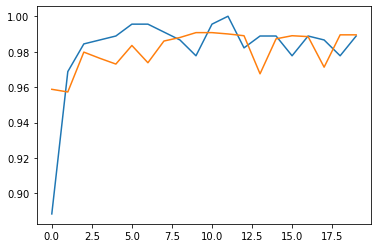

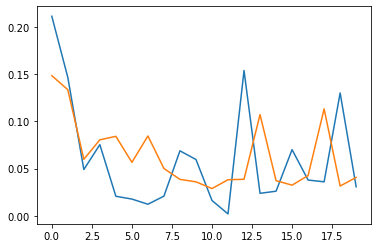

In [90]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs,acc)
plt.plot(epochs,val_acc)

plt.figure()

plt.plot(epochs,loss)
plt.plot(epochs,val_loss)

In [91]:
model.evaluate_generator(test_generator)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.06257908046245575, 0.987500011920929]

In [92]:
model.save('masknet.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
